In [1]:
# Notre DIP
!git clone https://github.com/quentgar/deep_image_prior.git
!mv deep_image_prior/* ./

!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep_image_prior'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 64 (delta 10), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (64/64), done.
Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 32.00 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [19]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from src.hourglass_network import *
import torch
import torch.optim

from utils.inpainting_utils import *
from skimage.measure import compare_psnr
from skimage.measure import block_reduce

import time

from mpl_toolkits.axes_grid1 import ImageGrid

import cv2

import matplotlib
from PIL import Image

from skimage.filters import gaussian, sobel, median, sobel_h, sobel_v

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [3]:
#Test pont
img_path = 'mydata/pont.jpg'
mask_path = 'mydata/pont_mask_2.jpg'

In [4]:
def crop_perso(img,d=32):
   new_size = (img.shape[1] - img.shape[1] % d, 
                img.shape[2] - img.shape[2] % d)

   img_cropped = img[:,int((img.shape[1] - new_size[0])/2):int((img.shape[1] + new_size[0])/2),
                     int((img.shape[2] - new_size[1])/2):int((img.shape[2] + new_size[1])/2)]
                     
   return img_cropped

In [5]:
def redim(img_orig, img_prec):
  new_size = (min(img_orig.shape[1], img_prec.shape[1]),
              min(img_orig.shape[2], img_prec.shape[2]))
  
  img_orig = img_orig[:,int((img_orig.shape[1] - new_size[0])/2):int((img_orig.shape[1] + new_size[0])/2),
                     int((img_orig.shape[2] - new_size[1])/2):int((img_orig.shape[2] + new_size[1])/2)]

  img_prec = img_prec[:,int((img_prec.shape[1] - new_size[0])/2):int((img_prec.shape[1] + new_size[0])/2),
                      int((img_prec.shape[2] - new_size[1])/2):int((img_prec.shape[2] + new_size[1])/2)]

  return img_orig, img_prec

## Image de base

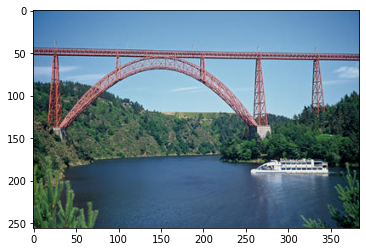

In [6]:
img_pil, img_np = get_image(img_path, imsize)
img_np = crop_perso(img_np, dim_div_by)
plt.imshow(img_np.transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


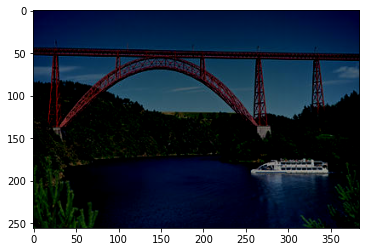

In [23]:
res = gaussian(img_np,100)
data = img_np - res
plt.imshow(data.transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 384)


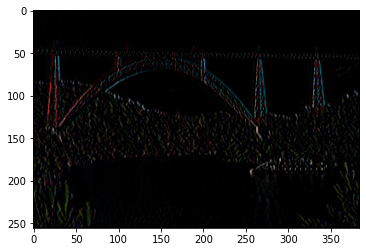

In [21]:
res = np.array([sobel_v(img_np[0,:,:]), sobel_v(img_np[1,:,:]), sobel_v(img_np[2,:,:])])
print(res.shape)
plt.imshow(res.transpose(1,2,0))

In [9]:
# Charger le masque à la dimension de img_np et arrondir
img_mask_pil, img_mask_np = get_image(mask_path, (img_np.shape[2],img_np.shape[1]))
img_mask_np = np.round(img_mask_np)

In [10]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

num_iter_list = [1000,1200,1500,2000]
sigma_list = [8,5,3,0]
LR_list = [0.01,0.0075,0.005,0.001]

# Sobel + transfer learning

In [24]:
start_time = time.time()

INPUT = 'noise'
input_depth = 2
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03

max_etage = 3

# Loss
mse = torch.nn.MSELoss().type(dtype)

# Profondeur
depth = 5

mask_var = np_to_torch(img_mask_np).type(dtype)

# Création du réseau
net = build_hourglass(input_depth, output_depth=img_np.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)

               

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

print("\nDIP CONTOURS \n")

LR = 0.01
num_iter = 2000

#img_d = np.array([sobel(img_np[0,:,:]), sobel(img_np[1,:,:]), sobel(img_np[2,:,:])])
img_d = img_np - gaussian(img_np,100)
img_var = np_to_torch(img_d).type(dtype)
  
i = 0
list_iter = []
list_psnr = []
list_loss = []
def closure():
    
    global i, list_iter, list_psnr, list_loss, e, img_d, img_var
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std  > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)

    total_loss.backward()
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        out_np = torch_to_np(out)
        list_iter.append(i)
        list_psnr.append(compare_psnr(img_d,out_np))
        list_loss.append(total_loss.item())
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

img_d = img_np
img_var = np_to_torch(img_d).type(dtype)
num_iter = 2000
LR = 0.01

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

end_time = time.time()

Output hidden; open in https://colab.research.google.com to view.

# Multi scale gaussian

In [88]:
start_time = time.time()

INPUT = 'noise'
input_depth = 2
LR = 0.01
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03

max_etage = 3

# Loss
mse = torch.nn.MSELoss().type(dtype)

# Profondeur
depth = 5

mask_var = np_to_torch(img_mask_np).type(dtype)

# Création du réseau
net = build_hourglass(input_depth, output_depth=img_np.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)

               

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

for e in range(max_etage,-1,-1):

  print("\nETAGE ",e,"\n")

  num_iter = num_iter_list[max_etage-e]
  LR = LR_list[max_etage-e]

  # Ajouter flou gaussian filter
  sigma = sigma_list[max_etage-e]
  img_d = gaussian(img_np,sigma)

  img_var = np_to_torch(img_d).type(dtype)

  i = 0
  list_iter = []
  list_psnr = []
  list_loss = []
  def closure():
      
      global i, list_iter, list_psnr, list_loss, e
      
      if param_noise:
          for n in [x for x in net.parameters() if len(x.size()) == 4]:
              n = n + n.detach().clone().normal_() * n.std() / 50
      
      net_input = net_input_saved
      if reg_noise_std  > 0:
          net_input = net_input_saved + (noise.normal_() * reg_noise_std)
          
          
      out = net(net_input)

      total_loss = mse(out * mask_var, img_var * mask_var)

      total_loss.backward()
          
      if PLOT and i % show_every == 0:
          print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
          
          out_np = torch_to_np(out)
          list_iter.append(i)
          list_psnr.append(compare_psnr(img_d,out_np))
          list_loss.append(total_loss.item())
          plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
          
      i += 1

      return total_loss

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  p = get_params(OPT_OVER, net, net_input)
  optimize(OPTIMIZER, p, closure, LR, num_iter)

  plt.figure()
  plt.plot(list_iter,list_psnr,linestyle='-')
  plt.title("PSNR en fonction du nombre d'itérations")
  plt.xlabel("Nombre d'itérations")
  plt.show()

end_time = time.time()

Output hidden; open in https://colab.research.google.com to view.

In [89]:
total_time = end_time - start_time
minutes = int(total_time // 60)
secondes = int(total_time % 60)
print("--- %s minutes %s secondes ---" % (minutes, secondes))

--- 14 minutes 16 secondes ---


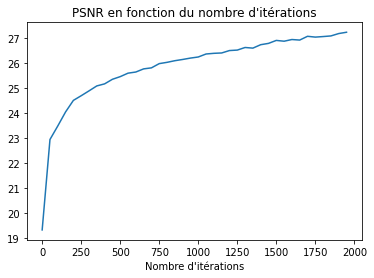

In [90]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

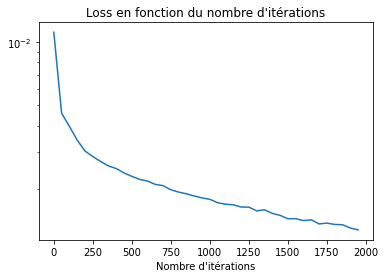

In [91]:
plt.figure()
plt.semilogy(list_iter,list_loss,linestyle='-')
plt.title("Loss en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

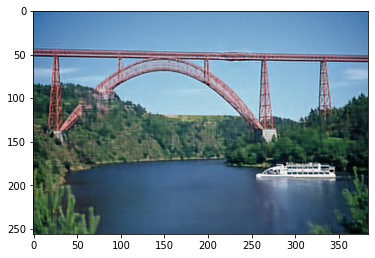

In [92]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [93]:
compare_psnr(img_np,out_np)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


27.263535780268498

In [94]:
max(list_psnr)

27.238660343506957

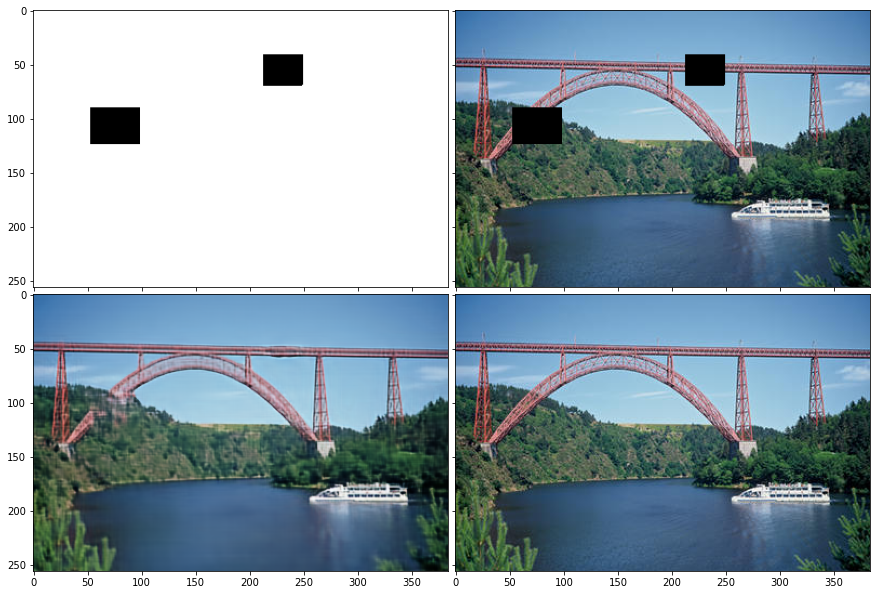

In [95]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img_mask_np, img_mask_np*img_np, out_np, img_np]):
    ax.imshow(im.transpose(1,2,0))

plt.show()